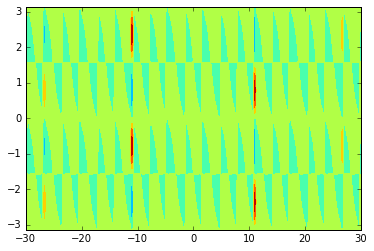

In [5]:
import sympy as sym
import numpy as np
from IPython.display import display, Math, Latex
sym.init_printing(use_unicode=True)

x,y,a,b,c=sym.symbols('x y a b c')
func = (sym.cos(a*y)**2*sym.sin(b*x))
deriv = sym.diff(func,x)+sym.diff(func,y)
display(deriv)
function=sym.lambdify((x,y,a,b,c),func,modules='numpy')
D=sym.lambdify((x,y,a,b,c),deriv,modules='numpy')

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def test(a,b,c):
    xv = np.linspace(-30,30,200)
    yv = np.linspace(-np.pi,np.pi,200)
    xv,yv = np.meshgrid(xv,yv)
    #print(D(xv,yv,1,1,2))
    plt.contourf(xv,yv,D(xv,yv,1,1,2)/np.cos(xv))
    plt.show()

test(4,5,6)

In [9]:
from pylab import *
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

def stab_squeez(x,theta,dela,loss,kapa,ra,kta,phia,La,thetapa,kapb,rb,ktb,phib,Lb,thetapb,nui,nuf,N,fig,switch):
	### PARAMETERS ####
	#Most of the parameters are given without the constant pi or 2pi.
	kapa = kapa*2.*pi       #\kappa_a (overall coupling for mode a)
	kapb = kapb*2.*pi       #\kappa_b (overall coupling for mode b)
	theta = theta*pi        #\theta (coherent pump phase)
	thetapa = thetapa*pi    #\theta^\prime_a (local oscillator phase for mode a)
	thetapb = thetapb*pi    #\theta^\prime_b (local oscillator phase for mode b)
	phia = phia*pi          #\phi_a (overall phase shift for mode a)
	phib = phib*pi          #\phi_b (overall phase shift for mode b)
	N = N*1000 +1           #resolution of frequencies

	#Parameters calculated from the input parameters
	eps   = x*kapa*exp(1j*theta)                #\epsilon (the coherent pump amplitude)
	Del   = kapa*dela                           #\Delta (detuning of modes a, same as for b but in the opposite direction)
	ta    = kta/kapa                           #\tau_a (time delay in mode a)
	tb    = ktb/kapb                           #\tau_b (time delay in mode b)
	kap1a = kapa * ra                         #\kappa_{1,a} (coupling on the right hand side in mode a)
	kap1b = kapb * rb                         #\kappa_{1,b} (coupling on the right hand side in mode b)
	kap2a = kapa * (1-ra)                     #\kappa_{2,a} (coupling on the left hand side in mode a)
	kap2b = kapb * (1-rb)                     #\kappa_{2,b} (coupling on the left hand side in mode b)
    
	#Frequency range initialization (nui:min, nuf:max, N:number of points)
	nu = linspace(nui*2.*pi,nuf*2.*pi,N)
    
	def Squeez(eps,theta,Del,kapa,kap1a,kap2a,kta,phia,La,thetapa,kapb,kap1b,kap2b,ktb,phib,Lb,thetapb,nu):
		ka = 2*sqrt(ra*(1-ra)*(1-La/100.))*kapa    #k_a (feedback strength in mode a)
		kb = 2*sqrt(rb*(1-rb)*(1-Lb/100.))*kapb    #k_b (feedback strength in mode b)

		### EXPRESSIONS ###
		def Ei(nu,t,phi):
			return np.exp(1j*(nu*t+phi))
		def d(nu,t,phi,kap,Del,k): #dpa if Del&phi, dma if -Del&-phi, dmb if Del&-phi, dpb if -Del&phi
			return kap - 1j*(nu+Del) + k*Ei(nu,t,-phi)
		def Lf(nu,Del,tp,phip,kapp,kp,tm,phim,kapm,km):#Lab if Del&p is a
			return abs(eps)**2 - d(nu,tp,phip,kapp,Del,kp)*d(nu,tm,-phim,kapm,Del,km)
		print(Lf(0,Del,ta,phia,kapa,ka,tb,phib,kapb,kb))
		def albe(nu,t,phi,kap1,kap2,L): #alpha if quantities for a 1 is order is kept
			return sqrt(2*kap1) + sqrt(2*kap2*(1-L/100.))*Ei(nu,t,phi)

		def D(nu,Del,tp,phip,kapp,kp,tm,phim,kapm,km,kap1,kap2,L): #Da if p is for b
			return sqrt(1-L/100.)*Lf(nu,-Del,tp,phip,kapp,kp,tm,phim,kapm,km)*Ei(nu,tm,phim) +\
			d(nu,tp,phip,kapp,-Del,kp)*albe(nu,tm,phim,kap1,kap2,L)*albe(nu,tm,phim,kap2,kap1,L)

		def E(nu,Del,tp,phip,kapp,kp,tm,phim,kapm,km,kap1,kap2,L): # Da if p is for b
			return sqrt(L/100.)*(sqrt(2*kap2)*d(nu,tp,phip,kapp,-Del,kp)*albe(nu,tm,phim,kap2,kap1,L) +\
			Lf(nu,-Del,tp,phip,kapp,kp,tm,phim,kapm,km))

		Mba = exp(1j*(theta-(thetapa+thetapb)/2))*albe(-nu,ta,phia,kap2a,kap1a,La) * \
		(D(nu,-Del,ta,phia,kapa,ka,tb,phib,kapb,kb,kap1b,kap2b,Lb)*np.conj(albe(nu,tb,phib,kap1b,kap2b,Lb)) + \
		sqrt(2*Lb/100.*kap2b)*E(nu,-Del,ta,phia,kapa,ka,tb,phib,kapb,kb,kap1b,kap2b,Lb))
		Mab = exp(1j*(theta-(thetapa+thetapb)/2))*albe(-nu,tb,phib,kap2b,kap1b,Lb) * \
		(D(nu,Del,tb,phib,kapb,kb,ta,phia,kapa,ka,kap1a,kap2a,La)*np.conj(albe(nu,ta,phia,kap1a,kap2a,La)) + \
		sqrt(2*La/100.*kap2a)*E(nu,Del,tb,phib,kapb,kb,ta,phia,kapa,ka,kap1a,kap2a,La))
		Nba = abs(eps)/2.*(np.abs(albe(-nu,ta,phia,kap2a,kap1a,La))**2 * \
                           (np.abs(albe(nu,tb,phib,kap1b,kap2b,Lb))**2+2*Lb/100.*kap2b)+\
		np.abs(albe(nu,tb,phib,kap2b,kap1b,Lb))**2*(np.abs(albe(-nu,ta,phia,kap1a,kap2a,La))**2+2*La/100.*kap2a))
		Nab = abs(eps)/2.*(np.abs(albe(-nu,tb,phib,kap2b,kap1b,Lb))**2 * \
                           (np.abs(albe(nu,ta,phia,kap1a,kap2a,La))**2+2*La/100.*kap2a)+\
		np.abs(albe(nu,ta,phia,kap2a,kap1a,La))**2*(np.abs(albe(-nu,tb,phib,kap1b,kap2b,Lb))**2+2*Lb/100.*kap2b))

		### CORRELATIONS ###
		ncorr = abs(eps)*(1/np.abs(Lf(nu,Del,ta,phia,kapa,ka,tb,phib,kapb,kb))**2*(np.real(Mba)+Nba)+\
		1/np.abs(Lf(nu,-Del,tb,phib,kapb,kb,ta,phia,kapa,ka))**2*(np.real(Mab)+Nab))   #(normalized)
		Sout  = 10*np.log10(1+ncorr)
		return Sout
        
	Sout_fb  = Squeez(eps,theta,Del,kapa,kap1a,kap2a,kta,phia,La,thetapa,kapb,kap1b,kap2b,ktb,phib,Lb,thetapb,nu)    
	Sout_th  = 10*np.log10(1+4*eps*kap1a/((eps-kapa)**2+nu**2))    
	Sout_th1 = 10*np.log10(1+4*eps*kapa/((eps-kapa)**2+nu**2))    
    
	## STABILITY ##    
	ka    = 2*sqrt(ra*(1-ra)*(1-La/100.))*kapa    #k_a (feedback strength in mode a)
	kb    = 2*sqrt(rb*(1-rb)*(1-Lb/100.))*kapb    #k_b (feedback strength in mode b)
    
	## Functions ##
	def Ra(lambr,lambi):
		return lambr+1j*lambi*2*pi+kapa+ka*cos(phia)*exp(-(1j*2*np.pi*lambi+lambr)*ta)
	def Ia(lambr,lambi):
		return Del+ka*sin(phia)*exp(-(1j*2*np.pi*lambi+lambr)*ta)
	def Rb(lambr,lambi):
		return lambr+1j*lambi*2*pi+kapb+kb*cos(phib)*exp(-(1j*2*np.pi*lambi+lambr)*tb)
	def Ib(lambr,lambi):
		return Del-kb*sin(phib)*exp(-(1j*2*np.pi*lambi+lambr)*tb)
    
	## Equations ##
	def eq1(lambr, lambi):
		return (Ra(lambr,lambi)+1j*Ia(lambr,lambi))*(Rb(lambr,lambi)+1j*Ib(lambr,lambi)) - eps**2
	def equation1(l):
		equations = [np.real(eq1(l[0],l[1]))]
		equations.append(np.imag(eq1(l[0],l[1])))
		return equations
	def eq2(lambr, lambi):
		return (Ra(lambr,lambi)-1j*Ia(lambr,lambi))*(Rb(lambr,lambi)-1j*Ib(lambr,lambi)) - eps**2
	def equation2(l):
		equations = [np.real(eq2(l[0],l[1]))]
		equations.append(np.imag(eq2(l[0],l[1])))
		return equations
	
	## Grid ##
	lr = np.linspace(-20,20,200)
	li = np.linspace(-30,30,200)
	lr,li = np.meshgrid(lr,li)

	## Solving the stability equations ##
	lamb1 = np.zeros(2)
	lamb2 = np.zeros(2)
	lamb1 = fsolve(equation1,[10,5])
	lamb2 = fsolve(equation2,[10,5])
	lambr = np.array([lamb1[0],lamb1[0],lamb2[0],lamb2[0]])
	lambi = np.array([lamb1[1],-lamb1[1],lamb2[1],-lamb2[1]])    
    
	## Figures ##
    
	### Linestyles ###
	colors={'brown':(200/255.,154/255.,125/255.),\
			'green':(0,151/255.,78/255.),\
			'blue':(0,120/255.,180/255.),\
			'yellow':(1., 215/255., 0),\
			'black':(0.,0.,0.)}
	collab = ['brown','green','blue','yellow','black']
	linewidth = [2,2,3,3,4]
	linestyle = ['solid','dashed','dashdot','dotted','solid']

	### Squeezing spectrum ###
	fsfont = {'fontname':'FreeSerif'}
	axsq = fig.add_axes([.15,.15,.8,.8]) # main axes
	axsq.hold(True)
	axsq.set_xlabel('$\\nu/(2\pi)$ (MHz)',fontsize = 30,**fsfont)
	axsq.set_ylabel('$S_{out,\\theta^\\prime} (\\nu)$ (dB)',fontsize = 30,**fsfont)
#	axsq.set_ylim(-30,30)
	axsq.xaxis.set_label_coords(0.5, -0.08)
	axsq.yaxis.set_label_coords(-0.08,0.5)
	plt.xticks(fontsize = 21,**fsfont)
	plt.yticks(fontsize = 21,**fsfont)
	axsq.plot(nu/2/pi,np.real(Sout_fb),color = colors["brown"],linewidth = 2,linestyle="solid")
	axsq.grid(True)
	axsq.hold(True)
	if switch==True:
		Sout_fbL = Squeez(eps,theta,Del,kapa,kap1a,kap2a,kta,phia,La+loss,thetapa,kapb,kap1b,kap2b,ktb,phib,Lb+loss,thetapb,nu)    
		axsq.plot(nu/2/pi,np.real(Sout_fbL),color = colors["green"],linewidth = 3,linestyle="dashdot")
	else:
		Sout_fbN = Squeez(eps,theta,Del,kapa,kap1a,kap2a,kta,phia,La+loss,thetapa,kapb,kap1b,kap2b,ktb,phib,100,thetapb,nu)    
		axsq.plot(nu/2/pi,np.real(Sout_fbN),color = colors["green"],linewidth = 3,linestyle="dashdot")
	axsq.plot(nu/2/pi,np.real(Sout_th),color = colors["yellow"],linewidth = 4,linestyle="dotted")
	axsq.plot(nu/2/pi,np.real(Sout_th1),color = colors["blue"],linewidth = 2,linestyle="dashed")
	#for i in range(4):
	#    axsq.plot(nu,Squeez[:,i],color = colors[collab[i]],linewidth = linewidth[i],linestyle=linestyle[i])
	#    axsq.grid(True)

	### Stability inset ###
	axst=fig.add_axes([0.21,0.23,0.2,0.35])
	axst.contour(lr,li,np.real(eq1(lr,li)),[0],colors='b')
	axst.hold(True)
	axst.contour(lr,li,np.real(eq2(lr,li)),[0],colors='b')
	axst.contour(lr,li,np.imag(eq1(lr,li)),[0],colors='g')
	axst.contour(lr,li,np.imag(eq2(lr,li)),[0],colors='g')
	axst.contour(lr,li,lr,[0],colors='grey',linestyles='dashed')
	axst.plot(lambr,lambi,'o',color = 'r')
	axst.grid(True)
	plt.xticks(fontsize = 14,**fsfont,rotation=60)
	plt.yticks(fontsize = 14,**fsfont,rotation=0)
	axst.set_xlabel('$\lambda_r (MHz)$',fontsize = 16,**fsfont)
	axst.set_ylabel('$\lambda_i (MHz)$',fontsize = 16,**fsfont)
	axst.xaxis.set_label_coords(0.5, -0.12)
	axst.yaxis.set_label_coords(-0.14,0.5)
	axst.set_xlim(-20,20)
	
#stab_squeez(x,theta,dela,loss,kapa,ra,kta,phia,La,thetapa,kapb,rb,ktb,phib,Lb,thetapb,nui,nuf,N,fig,switch):
##switch is True if some loss is necessary besides the lossless calculation,
##and False if one of the loops (b) is switched off

fig = plt.figure()
stab_squeez(.4,1,0.1,10,10,0.5,4.65,0.,0,0.0,2.5,0.75,0.403,0.04,0,0,-30,30,20,fig,True)
fig2 = plt.figure()
stab_squeez(0.6875,1,0.,10,10,0.5,2.,0.,0.,0,10,0.5,2.,0.,0.0,0,-30,30,20,fig2,True)
fig3 = plt.figure()
stab_squeez(0.5,1,0.,10,10,0.5,4.2,0.,0.,0,10,0.5,2,0.,0.0,0,-30,30,20,fig3,True)
plt.show()

(-3009.48640395+758.810840371j)
(-2829.97360917+750.410215803j)
(-13925.3949597+0j)
(-13125.4303457+0j)
(-14804.4066016+0j)
(-14004.4419877+0j)


In [3]:
import sympy as sym
import numpy as np
#import pylab as pl
from IPython.display import display, Math, Latex
sym.init_printing(use_unicode=True)

eps,Del,nu,nup,ta,tb,phia,phib,kapa,kapb,ka,kb =\
sym.symbols('|\epsilon| \Delta \\nu \\nu_p \\tau_a \\tau_b \phi_a \phi_b \kappa_a \kappa_b k_a k_b',real=True)
kap1a,kap1b,kap2a,kap2b,La,Lb = \
sym.symbols('\kappa_{1a} \kappa_{1b} \kappa_{2a} \kappa_{2b} L_a L_b',real=True)

#Functions for evaluation
Ema = sym.exp(sym.I*(-nu*ta+phia))
Emb = sym.exp(sym.I*(-nu*tb+phib))
Epa = sym.exp(sym.I*(nu*ta+phia))
Epb = sym.exp(sym.I*(nu*tb+phib))
dma = kapa-sym.I*(nu-Del) + ka*Epa         #d_{-,a}(\nu)
dmb = kapb-sym.I*(nu+Del) + kb*Epb         #d_{-,b}(\nu)
dpa = kapa-sym.I*(nu+Del) + ka*sym.conjugate(Ema)   #d_{+,a}(\nu)
dpb = kapb-sym.I*(nu-Del) + kb*sym.conjugate(Emb)   #d_{+,b}(\nu)
Lab = sym.Abs(eps)**2 - dpa*dmb          #\Lambda_{ab}(\nu)
Lba = sym.Abs(eps)**2 - dpb*dma          #\Lambda_{ba}(\nu)

alpha1p = sym.sqrt(2*kap1a)+sym.sqrt(2*kap2a*(1-La))*Epa   #\alpha_1(\nu)
alpha2p = sym.sqrt(2*kap2a)+sym.sqrt(2*kap1a*(1-La))*Epa   #\alpha_2(\nu)
beta1p  = sym.sqrt(2*kap1b)+sym.sqrt(2*kap2b*(1-Lb))*Epb   #\beta_1(\nu)
beta2p  = sym.sqrt(2*kap2b)+sym.sqrt(2*kap1b*(1-Lb))*Epb   #\beta_2(\nu)
alpha1m = sym.sqrt(2*kap1a)+sym.sqrt(2*kap2a*(1-La))*Ema   #\alpha_1(-\nu)
alpha2m = sym.sqrt(2*kap2a)+sym.sqrt(2*kap1a*(1-La))*Ema   #\alpha_2(-\nu)
beta1m  = sym.sqrt(2*kap1b)+sym.sqrt(2*kap2b*(1-Lb))*Emb   #\beta_1(-\nu)
beta2m  = sym.sqrt(2*kap2b)+sym.sqrt(2*kap1b*(1-Lb))*Emb   #\beta_2(-\nu)

Da  = sym.sqrt(1-La/100.)*Lba*Epa+dpb*alpha1p*alpha2p
Db  = sym.sqrt(1-Lb/100.)*Lab*Epb+dpa*beta1p*beta2p
Ea  = sym.sqrt(La/100.)*(sym.sqrt(2*kap2a)*dpb*alpha2p+Lba)
Eb  = sym.sqrt(Lb/100.)*(sym.sqrt(2*kap2b)*dpa*beta2p+Lab)
KLa = kapa+ka*sym.cos(phia-nu*ta)-kap1a*La
Ka  = kapa+ka*sym.cos(phia-nu*ta)
KLb = kapb+kb*sym.cos(phib-nu*tb)-kap1b*Lb
Kb  = kapb+kb*sym.cos(phib-nu*tb)

#Uncertainties in I
U1ab = 4*KLa*Kb
U2ab = Da.subs(nu,nup)*sym.conjugate(Da.subs(nu,nup)) + Ea.subs(nu,nup)*sym.conjugate(Ea.subs(nu,nup))
U3ab = sym.conjugate(alpha2m)*(beta1p*sym.conjugate(Db) + sym.sqrt(2*kap2b*Lb)*sym.conjugate(Eb))
U4ab = beta2m.subs(nu,nup)*(Da.subs(nu,nup)*sym.conjugate(alpha1p) + \
                            sym.sqrt(2*kap2a*La)*sym.conjugate(Ea.subs(nu,nup)))

U1ba = 4*KLb*Ka
U2ba = Db.subs(nu,nup)*sym.conjugate(Db.subs(nu,nup)) + Eb.subs(nu,nup)*sym.conjugate(Eb.subs(nu,nup))
U3ba = sym.conjugate(beta2m)*(alpha1p*sym.conjugate(Da) + sym.sqrt(2*kap2a*La)*sym.conjugate(Ea))
U4ba = alpha2m.subs(nu,nup)*(Db.subs(nu,nup)*sym.conjugate(beta1p) + \
                            sym.sqrt(2*kap2b*Lb)*sym.conjugate(Eb.subs(nu,nup)))

#Expectation value of the outgoing photon number
nom_ba = (kapa+ka*sym.cos(phia-nu*ta)-kap1a*La)*(kapb+kb*sym.cos(phib+nu*tb))
nom_ab = (kapb+kb*sym.cos(phib-nu*tb)-kap1b*Lb)*(kapa+ka*sym.cos(phia+nu*ta))
I_exp  = 4*eps**2*(nom_ba/(Lab*sym.conjugate(Lab))-nom_ab/(Lba*sym.conjugate(Lba)))
I_phid = 1/2*(sym.diff(I_exp,phia)-sym.diff(I_exp,phib))

T1_nu  = eps**2*U1ab/(Lab*sym.conjugate(Lab))/I_phid
T1_nup = eps**2*U2ab/(Lba.subs(nu,nup)*sym.conjugate(Lba.subs(nu,nup)))/I_phid.subs(nu,nup)
T2_nu  = eps**2*U3ab/(Lab*sym.conjugate(Lab))/I_phid
T2_nup = eps**2*U4ab/(Lba.subs(nu,nup)*sym.conjugate(Lba.subs(nu,nup)))/I_phid.subs(nu,nup)
T3_nu  = eps**2*U1ba/(Lba*sym.conjugate(Lba))/I_phid
T3_nup = eps**2*U2ba/(Lab.subs(nu,nup)*sym.conjugate(Lab.subs(nu,nup)))/I_phid.subs(nu,nup)
T4_nu  = eps**2*U3ba/(Lba*sym.conjugate(Lba))/I_phid
T4_nup = eps**2*U4ba/(Lab.subs(nu,nup)*sym.conjugate(Lab.subs(nu,nup)))/I_phid.subs(nu,nup)

T1 = sym.integrate(T1_nu,(nu,-sym.oo,sym.oo))*sym.integrate(T1_nup,(nup,-sym.oo,sym.oo))
T2 = sym.integrate(T2_nu,(nu,-sym.oo,sym.oo))*sym.integrate(T2_nup,(nup,-sym.oo,sym.oo))
T3 = sym.integrate(T3_nu,(nu,-sym.oo,sym.oo))*sym.integrate(T3_nup,(nup,-sym.oo,sym.oo))
T4 = sym.integrate(T4_nu,(nu,-sym.oo,sym.oo))*sym.integrate(T4_nup,(nup,-sym.oo,sym.oo))

sens = T1+T2+T3+T4

KeyboardInterrupt: 